# Determine acceleration with Kalman filter for all tests

# Purpose
Yaw rate, Yaw acceleration and Yaw jerk are missing from the model test. These signals can be estimated with Kalman filters. This will be done for all runs in this project.

# Methodology
Loop through all tests and determine the "hidden states" with Kalman filters.

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp
import seaborn as sns

## Local packages:
from src.data import mdl




Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from src.data import kalman_filter

In [3]:
id=22773
df, units, meta_data = mdl.load(id=id)

In [4]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:13.700013,0.0,1.0,2.146755,0.798334,0.104886,15.505859,2.567061,57.348541,0.8,2.146755,1.009509,0.163203,15.505859,3.341054,58.867588,0.010956,-0.002530,-0.000086,0.000233,-0.005931,0.001067,9.569964,5.505012,-0.115821,9.590799,5.687483,0.111180,-0.000007,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001138,0.000295,0.000087,7.164215,-0.000099,0.002467
0 days 00:00:13.710002,0.0,1.0,2.146755,0.798334,-0.143440,15.505859,1.447828,57.348541,0.8,2.146755,1.009509,0.084455,15.505859,4.807634,58.867588,0.001283,-0.003820,-0.007830,0.003454,-0.005931,0.009445,9.628717,5.555121,-0.116216,9.541293,5.671445,0.108954,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001158,-0.000311,0.000087,7.164259,-0.000180,0.002405
0 days 00:00:13.720003,0.0,1.0,2.146755,0.798334,-0.360041,15.505859,1.621502,57.348541,0.8,2.146755,1.009509,-0.049593,15.505859,-0.421882,58.867588,0.010311,0.001982,-0.007830,0.013117,-0.006576,-0.001511,9.603547,5.633792,-0.114932,9.556246,5.599838,0.105735,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001134,0.000372,0.000087,7.183286,-0.000100,0.002487
0 days 00:00:13.730005,0.0,1.0,2.146755,0.798334,-0.380839,15.505859,1.698691,57.348541,0.8,2.146755,1.009509,-0.133511,15.505859,5.367251,58.867588,-0.008389,-0.004464,-0.009121,0.000877,-0.005286,0.001711,9.572272,5.710973,-0.112320,9.540091,5.487629,0.102544,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001152,-0.000409,0.000087,7.183280,-0.000181,0.002469
0 days 00:00:13.740018,0.0,1.0,2.146755,0.798334,-0.173223,15.505859,2.084633,57.348541,0.8,2.146755,1.009509,-0.117504,15.505859,1.797285,58.867588,0.007087,0.006495,-0.009121,0.009252,-0.001418,-0.004733,9.564290,5.755025,-0.109036,9.560101,5.364202,0.100559,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001127,0.000531,0.000087,7.193513,-0.000101,0.002443


In [6]:
df1 = kalman_filter.yaw(df=df, observation_covariance=0.5)
df2 = kalman_filter.yaw(df=df, observation_covariance=1000)
df3 = kalman_filter.yaw(df=df, observation_covariance=1000000)


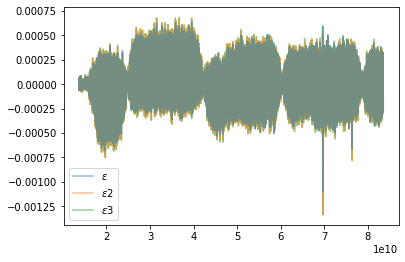

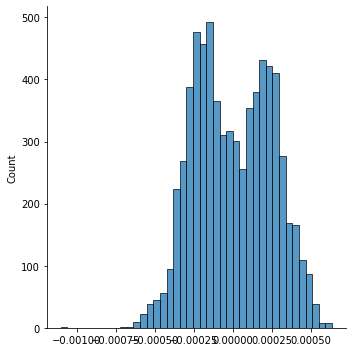

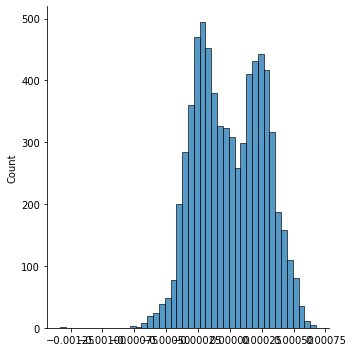

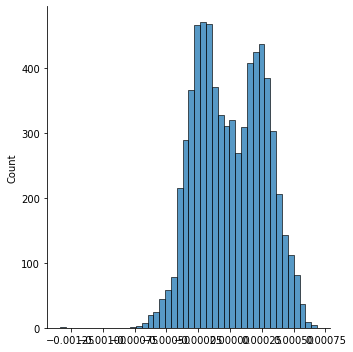

In [7]:
epsilon1 = df1['psi']-df1['psi_filtered']
epsilon2 = df2['psi']-df2['psi_filtered']
epsilon3 = df3['psi']-df3['psi_filtered']

fig,ax=plt.subplots()
ax.plot(df.index,  epsilon1  ,label=r'$\epsilon$', alpha=0.5, zorder=3)
ax.plot(df.index,  epsilon2 ,label=r'$\epsilon2$', alpha=0.5, zorder=2)
ax.plot(df.index,  epsilon3 ,label=r'$\epsilon3$', alpha=0.5, zorder=1)
ax.legend()

sns.displot(epsilon1)
sns.displot(epsilon2)
sns.displot(epsilon3)

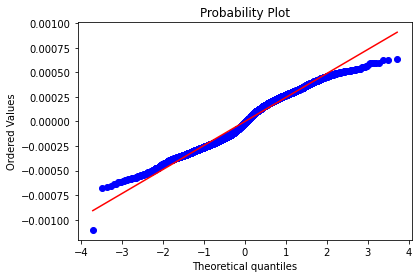

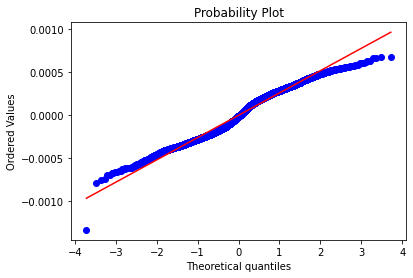

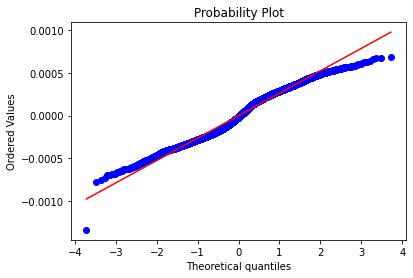

In [8]:
import scipy.stats as stats
fig,ax=plt.subplots()
stats.probplot(epsilon1, dist="norm", plot=ax);

fig,ax=plt.subplots()
stats.probplot(epsilon2, dist="norm", plot=ax);

fig,ax=plt.subplots()
stats.probplot(epsilon3, dist="norm", plot=ax);



In [9]:
df_runs = pd.read_csv('../data/raw/runs.csv', index_col=0)

In [11]:
save_dir = '../data/processed/kalman'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for id, row in df_runs.iterrows():
    
    print(f'working on:{id}')
    df = mdl.load_run(id=id)
    df = kalman_filter.filter_and_transform(df=df)
    
    df.index = df.index.total_seconds()
    save_name = f'{id}.csv'
    save_path = os.path.join(save_dir,save_name)
    df.to_csv(save_path)
    

working on:22605
working on:22606
working on:22607
working on:22608
working on:22609
working on:22610
working on:22611
working on:22612
working on:22613
working on:22614
working on:22615
working on:22616
working on:22631
working on:22632
working on:22633
working on:22634
working on:22635
working on:22636
working on:22637
working on:22638
working on:22639
working on:22762
working on:22763
working on:22764
working on:22765
working on:22768
working on:22769
working on:22770
working on:22771
working on:22772
working on:22773
working on:22774
working on:22775
working on:22776
working on:22777
working on:22778
working on:22779
working on:22780
working on:22781
working on:22782
working on:22813
working on:22814
working on:22815
working on:22816
working on:22817
working on:22818
working on:22822
working on:22823
working on:22824
working on:22825
working on:22826
working on:22827
working on:22828
working on:22829
working on:22830
working on:22831
working on:22832
working on:22833
working on:228